In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'LazyGraphDataSet'#'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

#lCsvColName     = ['Transaction ID', 'Block Time', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash', 'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used', 'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level']
#lCsvColNameFlag = [True,              True,         True,               True,        True,          True,            True,     True,       True,            True,            True,           True,        True,        True,       True,            True,         True,          False,   False]  #<! Flags if a column is a must to have
lCsvColName = [
'Transaction ID',
'Transaction Time',
'Block Time',	
'Sender ID',	
'Receiver ID',	
'Receiver Type',	
'Amount',	
'Currency',	
'Currency Hash',	
'Currency Type',	
'Amount [USD]',	
'Gas Price',	
'Gas Limit',	
'Gas Used',	
'Gas Predicted',	
'Balance In',	
'Balance Out',	
'Label',	
'Risk Level',	
'From Block Time',
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out',	
'transactions_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_total_transfers_USD_amount_in',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out',	
'transfers_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transactions_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transactions_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_transfers_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_transfers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transfers_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transfers_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'total_transactions_count_between_sender_and_receiver_before_block_time',	
'total_transactions_unique_days_count_between_sender_and_receiver_before_block_time',	
'total_transfers_count_between_sender_and_receiver_before_block_time',	
'total_transfers_unique_days_count_between_sender_and_receiver_before_block_time',	
'transfers_first_transfer_date_between_senderID_receiverID_before_block_time',	
'transfers_days_count_between_senderID_and_receiverID_from_first_transfer_date_to_current_transaction_date',	
'transactions_first_transaction_date_between_senderID_receiverID_before_block_time',	
'transactions_days_count_between_senderID_and_receiverID_from_first_transaction_date_to_current_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transactions_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_smart_contract_created',	
'transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation',	
'transfers_sent_or_received_unique_currency_count',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count.1',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count.1',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_date',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_sent_transactions_count',	
'transfers_anonymous_activity_from_mixerID_as_sender_to_receiverID_as_receiver_before_block_time',	
'transfers_anonymous_activity_from_receiverID_as_sender_to_mixerID_as_receiver_before_block_time',	
'transfers_mixerID_and_receiverID_before_block_time_first_activity_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount_less_equal_to_one',	
'transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount',	
'transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count',	
'transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date']	
lCsvColNameFlag = [
True,
False,
True,	
True,	
True,	
True,	
True,	
True,	
False,#'Currency Hash',	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True
]



# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
#dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
dfData, dAssetFile =  LoadCsvFilesDf(lCsvFile, baseFoldePath = '', lColName = lCsvColName, lColFlag =  lCsvColNameFlag ,  addFileNameCol = True )

numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 117
The number of rows (Samples): 40296, The number of columns: 86, number of unique sender id's: (117,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'From Block Time',
       'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',
       'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',
       'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',
       'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',
       'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_trans

In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,...,transfers_anonymous_activity_from_mixerID_as_sender_to_receiverID_as_receiver_before_block_time,transfers_anonymous_activity_from_receiverID_as_sender_to_mixerID_as_receiver_before_block_time,transfers_mixerID_and_receiverID_before_block_time_first_activity_date,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount_less_equal_to_one,transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount,transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date,File Name
14044,0x82ca4e875d300d61552b2546c2f51bb630cab4eb35ca...,NaN,2017-02-23 11:05:43+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0x86ed2df3159171dd3fc8361ae0e7c59f46cf0ea7,Wallet,0.01,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,1.0,0.0,1.0,Multisig002.csv
14043,0x4ae416a730584c4d529d9bbaa08d193d86abff3b0f5e...,NaN,2017-02-28 12:01:26+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0xec466962b6d3e072f11ec455cc547178116290c8,Wallet,0.01,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig002.csv
14042,0x2025858cdebc50890745762750dbefedb6b6ce5066d2...,NaN,2017-03-23 11:37:47+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0x0017185703fda419403449447dd534e90b1fea70,Wallet,6000.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig002.csv
14041,0x3341bfb1d9fdac9ea7d8d8c3934fbdb79c2bc78525ab...,NaN,2017-03-24 13:36:38+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0x0017185703fda419403449447dd534e90b1fea70,Wallet,8000.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig002.csv
14034,0x29d83d0b0307ee07ab60249477193e9fe4169ee33169...,NaN,2017-03-28 09:31:02+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xa4e3e53e89e575b32249e6105da159a4f48d34de,Wallet,0.10,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,26.0,26.0,Multisig001.csv
14033,0x392fee353f3b9b74fb6461773d47807e4439c7648be8...,NaN,2017-03-28 11:09:50+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xa4e3e53e89e575b32249e6105da159a4f48d34de,Wallet,2.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,26.0,26.0,Multisig001.csv
14032,0x85529bcfd4cf817d8344676daaa80ebf1ff170d72c97...,NaN,2017-03-28 12:45:29+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xb6f2af0b3551161fe95f18219a8d402fc4e0233b,Wallet,2.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,929.0,64.0,993.0,Multisig001.csv
14031,0x8244ac208337494bd17d37b3fda6b52b0cea90062ac3...,NaN,2017-03-29 15:43:45+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0x2cceda9171806afd2716367ca0a1359156728513,Smart Contract,2000.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig001.csv
14040,0x8b8f6b1c3c62791def07e2dc220bf4fdcf8e7e9466c9...,NaN,2017-04-02 13:03:35+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0x0017185703fda419403449447dd534e90b1fea70,Wallet,1000.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig002.csv
14039,0x7c1941c65e7e6f805c84d3e3a7773376d72ad0c47add...,NaN,2017-04-18 12:09:54+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515

# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [10]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,...,transfers_anonymous_activity_from_mixerID_as_sender_to_receiverID_as_receiver_before_block_time,transfers_anonymous_activity_from_receiverID_as_sender_to_mixerID_as_receiver_before_block_time,transfers_mixerID_and_receiverID_before_block_time_first_activity_date,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount_less_equal_to_one,transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount,transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date,File Name
14036,0x0e0d16475d2ac6a4802437a35a21776e5c9b681a77fe...,NaN,2017-07-18 22:33:23+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,26793.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,1.0,0.0,1.0,Multisig002.csv
14008,0x97f7662322d56e1c54bd1bab39bccf98bc736fcb9c7e...,NaN,2017-07-19 12:14:18+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,44055.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,1.0,3.0,4.0,Multisig001.csv
14048,0xeef10fc5170f669b86c4cd0444882a96087221325f8b...,NaN,2017-07-19 12:19:36+00:00,0xbec591de75b8699a3ba52f073428822d0bfc0d7e,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,82189.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,1.0,5.0,6.0,Multisig003.csv
13055,0x283fd14161d9841571acdc4b629de597bfdcdd197647...,NaN,2017-08-21 05:11:33+00:00,0xa95842e41380100c12caf7b872baa77ce6d8ad24,0x29d7d1dd5b6f9c864d9db560d72a247c178ae86b,Wallet,10.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Enigma001.csv
13054,0xa22dafd9184d9eb54deb021d2467eb4e4aee84aee121...,NaN,2017-08-21 05:18:32+00:00,0xa95842e41380100c12caf7b872baa77ce6d8ad24,0x29d7d1dd5b6f9c864d9db560d72a247c178ae86b,Wallet,7.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,80.0,0.0,80.0,Enigma001.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39798,0xecc404208cf5a9b817b772ca0d51c4bfa02eae2b31a6...,NaN,2022-09-15 21:11:47+00:00,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,0x6ae09ac63487fcf63117a6d6fafa894473d47b93,NaN,7.538739,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Profanity001.csv
39803,0x64b7bbe7b879174663d88ca7ebad4ee7f0208a8699b8...,NaN,2022-09-16 07:12:11+00:00,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,0x6ae09ac63487fcf63117a6d6fafa894473d47b93,NaN,0.000010,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,11.0,0.0,11.0,Profanity001.csv
37999,0xbddb0cc8bc9949321e1748f03503ed1a20dd618fbf0a...,NaN,2022-09-16 08:49:47+00:00,0xa6439ca0fcba1d0f80df0be6a17220fed9c9038a,0x82faed2da812d2e5cced3c12b3baeb1a522dc677,NaN,200.000000,ETH,NaN,internal,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,2.0,89.0,91.0,Omni Bridge001.csv
38004,0xc3652f2ed07a9b7c60d7930ea1121c200585462ebfba...,NaN,2022-09-16 09:05:23+00:00,0xa6439ca0fcba1d0f80df0be6a17220fed9c9038a,0x82faed2da812d2e5cced3c12b3baeb1a522dc677,NaN,45.000000,ETH,NaN,internal,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,2.0,89.0,91.0,Omni Bridge001.csv


In [11]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    39708
1      588
Name: Label, dtype: int64

In [12]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

117

In [13]:
dfData['Label'].value_counts()

0    39708
1      588
Name: Label, dtype: int64

In [14]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40296 entries, 14044 to 39820
Data columns (total 86 columns):
 #   Column                                                                                                             Non-Null Count  Dtype              
---  ------                                                                                                             --------------  -----              
 0   Transaction ID                                                                                                     40296 non-null  object             
 1   Transaction Time                                                                                                   0 non-null      float64            
 2   Block Time                                                                                                         40296 non-null  datetime64[ns, UTC]
 3   Sender ID                                                                                             

In [15]:
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,...,transfers_sent_or_received_unique_currency_count,transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count.1,transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count.1,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count,transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_sent_transactions_count,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount,transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount,transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date
count,0.0,4.029600e+04,3.865100e+04,4.029600e+04,4.029600e+04,4.029600e+04,0.0,0.0,0.0,40296.000000,...,40296.000000,40296.000000,40296.000000,40296.00000,40296.000000,40296.000000,4.029600e+04,4.029600e+04,40296.000000,4.029600e+04
mean,NaN,2.878698e+72,5.493991e+05,8.941369e-08,6.448385e+05,3.388815e+05,NaN,NaN,NaN,0.014592,...,70.794446,59.353583,45.726449,104.20739,99.285587,1199.010586,1.814721e+03,3.029089e+04,74.286306,3.036518e+04
std,NaN,5.778658e+74,6.901579e+06,1.211827e-07,1.635720e+06,1.231489e+06,NaN,NaN,NaN,0.119914,...,393.405928,330.604100,254.667809,806.58422,793.030841,15276.986563,3.035623e+04,3.746647e+05,2638.597270,3.746680e+05
min,NaN,0.000000e+00,0.000000e+00,1.000000e-10,2.100000e+04,1.936000e+04,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,NaN,1.464938e-01,3.591788e+01,4.410000e-08,2.443980e+05,2.100000e+04,NaN,NaN,NaN,0.000000,...,2.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,NaN,1.379517e+00,4.138818e+02,7.000000e-08,2.500000e+05,1.116410e+05,NaN,NaN,NaN,0.000000,...,3.000000,3.000000,2.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
75%,NaN,1.620499e+01,3.423018e+03,8.800000e-08,4.500000e+05,2.306078e+05,NaN,NaN,NaN,0.000000,...,14.000000,14.000000,4.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
max,NaN,1.160000e+77,2.421620e+08,4.054923e-06,2.000000e+07,9.895111e+06,NaN,NaN,NaN,1.000000,...,8494.000000,8494.000000,5227.000000,9452.00000,10036.000000,461012.402344,1.223680e+06,8.640369e+06,522853.000000,8.640369e+06


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [16]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 2461


In [17]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [18]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [19]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [20]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 37835, The number of columns: 86


# Meet the Data

Basic infomration about the data.

In [21]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37835 entries, 14044 to 39820
Data columns (total 86 columns):
 #   Column                                                                                                             Non-Null Count  Dtype              
---  ------                                                                                                             --------------  -----              
 0   Transaction ID                                                                                                     37835 non-null  object             
 1   Transaction Time                                                                                                   0 non-null      float64            
 2   Block Time                                                                                                         37835 non-null  datetime64[ns, UTC]
 3   Sender ID                                                                                             

In [22]:
# Numeric Data Description
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,...,transfers_sent_or_received_unique_currency_count,transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count.1,transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count.1,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count,transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_sent_transactions_count,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount,transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount,transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date
count,0.0,3.783500e+04,3.783500e+04,3.783500e+04,3.783500e+04,3.783500e+04,0.0,0.0,0.0,37835.000000,...,37835.000000,37835.000000,37835.000000,37835.000000,37835.000000,37835.000000,3.783500e+04,3.783500e+04,37835.000000,3.783500e+04
mean,NaN,4.658518e+06,5.612482e+05,8.241747e-08,5.872607e+05,2.948535e+05,NaN,NaN,NaN,0.015435,...,59.416995,54.262270,35.333236,110.850985,105.742831,1218.362384,1.932421e+03,3.220730e+04,71.667900,3.227897e+04
std,NaN,2.631597e+08,6.975132e+06,1.093018e-07,1.530709e+06,1.134014e+06,NaN,NaN,NaN,0.123279,...,357.861108,330.042145,204.812629,831.969159,817.999564,15731.577396,3.132432e+04,3.864682e+05,2719.380672,3.864719e+05
min,NaN,1.000000e-18,2.750000e-20,1.000000e-10,2.100000e+04,2.008400e+04,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,NaN,1.597481e-01,4.350269e+01,4.450000e-08,2.443980e+05,2.100000e+04,NaN,NaN,NaN,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,NaN,1.342191e+00,4.573282e+02,6.834697e-08,2.500000e+05,9.961000e+04,NaN,NaN,NaN,0.000000,...,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
75%,NaN,1.250000e+01,3.543951e+03,8.800000e-08,4.332390e+05,2.185510e+05,NaN,NaN,NaN,0.000000,...,12.000000,12.000000,4.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
max,NaN,2.786965e+10,2.421620e+08,4.054923e-06,2.000000e+07,9.895111e+06,NaN,NaN,NaN,1.000000,...,8494.000000,8494.000000,5227.000000,9452.000000,10036.000000,461012.402344,1.223680e+06,8.640369e+06,522853.000000,8.640369e+06


In [23]:
# How many times each hacker attacked
dsAttacksAsset = dfData[dfData['Label'] == 1]['Receiver ID'].value_counts()

print(f'There are {dsAttacksAsset.shape[0]} Attackers')
print(dsAttacksAsset.head(len(dsAttacksAsset))) #<! Last ones should be 1

There are 67 Attackers
0x3aa27ab297a3a753f79c5497569ba2dacc2bc35a    106
0xb9864cebcc27136eb4657ffef534956eac78c15c    104
0x3f8a37bde9b15b65c82f9cdd00192e0ba36cc5fc     46
0x941a9e3b91e1cc015702b897c512d265fae88a9c     28
0x0000000a5aab7e0b99e8b30028d790de05da0f09     28
                                             ... 
0x601a1dd67a637fc3ff0141724152e15abe1905f7      1
0x03d1d0e4061152c6a698309aaa4968aae58585a8      1
0x3668c746398621d26f1f7b02f03276be586096d1      1
0x7c42f2a7d9ad01294ecef9be1e38272c84607593      1
0xeda5066780de29d00dfb54581a707ef6f52d8113      1
Name: Receiver ID, Length: 67, dtype: int64


In [24]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [25]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [26]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [27]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [28]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [29]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [30]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [31]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [32]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [33]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [34]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [35]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


In [ ]:
dfData.columns.shape

In [ ]:
'''
Block time minus from "U" to "AB" columns
U-V
W-X
Y-Z
AA-AB
BC-BE
Intervals
transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in divided by AK
transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in divided by AL
transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out divided by AI
transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out divided by AJ
AE divided by AC
AH divided by AF
AG divided by AQ
AG divided by AR
Count ratio of AU and AW
Count ratio of AI and AK
CD/CX
CB/BW

'''
#transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date	transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date	transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date	transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date	transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date	transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date	transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date	transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date


In [36]:
date_cols = [
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date',
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date',
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date',
'transfers_first_transfer_date_between_senderID_receiverID_before_block_time',
'transactions_first_transaction_date_between_senderID_receiverID_before_block_time'
]

for col in date_cols:
    dfData[col] = pd.to_datetime(dfData[col], infer_datetime_format = 'True') #<! Stable time format

In [37]:
new_cols = []
for col in date_cols:
    dfData[col+'_diff'] = (dfData['Block Time'] - dfData[col]).astype('timedelta64[h]').astype('float')
    new_cols.append(col+'_diff')

dfData['d1'] = (dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date'] - dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date']).astype('timedelta64[h]').astype('int')
dfData['d2'] = (dfData['transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date'] - dfData['transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date']).astype('timedelta64[h]').astype('int')
dfData['d3'] = (dfData['transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date']	- dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date']).astype('timedelta64[h]').astype('int')
dfData['d4'] = (dfData['transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date'] - dfData['transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date']).astype('timedelta64[h]').astype('int')
dfData['d5'] = (dfData['transfers_first_transfer_date_between_senderID_receiverID_before_block_time'] - dfData['transactions_first_transaction_date_between_senderID_receiverID_before_block_time']).astype('timedelta64[h]').astype('int')

dfData['r1'] = dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in']/dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count']
dfData['r2'] = dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in']/dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count']
dfData['r3'] = dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out']/dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count']
dfData['r4'] = dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out']/dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count']

dfData['r5'] = dfData['transactions_receiverID_as_receiver_from_any_sender_first_received_amount']/dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in']
dfData['r6'] = dfData['transfers_receiverID_as_receiver_from_any_sender_first_received_amount']/dfData['transfers_receiverID_as_receiver_from_any_sender_before_block_time_total_transfers_USD_amount_in']
dfData['r7'] = dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out']/dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_transfers_count']
dfData['r8'] = dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out']/dfData['transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count']
dfData['r9'] = dfData['transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transfers_count']/dfData['transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transfers_count']
dfData['r10'] = dfData['transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count']/dfData['transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count']
dfData['r11'] = dfData['transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount']/dfData['transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count']


new_cols.extend(['d1','d2','d3','d4','d5','r1','r2','r3','r4','r5','r6','r7','r8','r9','r10','r11'])



In [ ]:
#transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in/transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count divided by AK(ac/ak)
#transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in/transactions_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count divided by AL
#transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out/transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count divided by AI
#transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out/transactions_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count divided by AJ
#AE divided by AC = transactions_receiverID_as_receiver_from_any_sender_first_received_amount/transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in
#AH divided by AF = transfers_receiverID_as_receiver_from_any_sender_first_received_amount/transfers_receiverID_as_receiver_from_any_sender_before_block_time_total_transfers_USD_amount_in
#AG divided by AQ = transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out/transfers_receiverID_as_sender_to_any_receiver_before_block_time_transfers_count
#AG divided by AR = transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out/transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count
#Count ratio of AU and AW = transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transfers_count/transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transfers_count
#Count ratio of AI and AK = transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count/transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count
#CD/CX = transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount
#CB/BW = transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount/transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count
#U-V = transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date	transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date
#W-X = transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date	transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date
#Y-Z = transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date	transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date
#AA-AB = transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date	transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date
#BC-BE transfers_first_transfer_date_between_senderID_receiverID_before_block_time	transactions_first_transaction_date_between_senderID_receiverID_before_block_time


In [38]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

In [39]:
for col in ['Block Time', 
            'From Block Time', 
            'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date', 
            'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date', 
            'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date', 
            'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date', 
            'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date', 
            'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date', 
            'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date', 
            'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date', 
            'transfers_first_transfer_date_between_senderID_receiverID_before_block_time', 
            'transactions_first_transaction_date_between_senderID_receiverID_before_block_time',
             'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_date', 
             'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_date', 
             'transfers_mixerID_and_receiverID_before_block_time_first_activity_date']:



    print(col)         
    dfData_[col] =  pd.to_datetime(dfData_[col]).dt.tz_localize(None).astype(np.int64)
    #transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation

Block Time
From Block Time
transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date
transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date
transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date
transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date
transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date
transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date
transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date
transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date
transfers_first_transfer_date_between_senderID_receiverID_before_block_time
transactions_first_transaction_date_between_senderID_receiverID_before_block_time
transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_ti

## Features Visualization

### K-fold training, using categorical variables (EXPERIMENT)

In [40]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]


lNumericalFeatures = lNumericalFeatures + [ #[#lCsvColName = [
'Block Time',		
'Amount',	
'Amount [USD]',	
'Gas Price',	
'Gas Limit',	
'Gas Used',	
'Gas Predicted',	
'Balance In',	
'Balance Out',		
'Risk Level',	
'From Block Time',
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out',	
'transactions_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_total_transfers_USD_amount_in',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out',	
'transfers_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transactions_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transactions_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_transfers_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_transfers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transfers_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transfers_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'total_transactions_count_between_sender_and_receiver_before_block_time',	
'total_transactions_unique_days_count_between_sender_and_receiver_before_block_time',	
'total_transfers_count_between_sender_and_receiver_before_block_time',	
'total_transfers_unique_days_count_between_sender_and_receiver_before_block_time',	
'transfers_first_transfer_date_between_senderID_receiverID_before_block_time',	
'transfers_days_count_between_senderID_and_receiverID_from_first_transfer_date_to_current_transaction_date',	
'transactions_first_transaction_date_between_senderID_receiverID_before_block_time',	
'transactions_days_count_between_senderID_and_receiverID_from_first_transaction_date_to_current_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transactions_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_smart_contract_created',	
'transfers_sent_or_received_unique_currency_count',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count.1',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count.1',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_date',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_sent_transactions_count',	
'transfers_anonymous_activity_from_mixerID_as_sender_to_receiverID_as_receiver_before_block_time',	
'transfers_anonymous_activity_from_receiverID_as_sender_to_mixerID_as_receiver_before_block_time',	
'transfers_mixerID_and_receiverID_before_block_time_first_activity_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount_less_equal_to_one',	
'transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount',	
'transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count',	
'transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date']

#lNumericalFeatures.extend(new_cols)
lNumericalFeatures = list(set(lNumericalFeatures))
lTotalFeatures = lNumericalFeatures + lCatFeatures

In [ ]:
nn = ['transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date_diff',
 'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date_diff',
 'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date_diff',
 'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date_diff',
 'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date_diff',
 'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date_diff',
 'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date_diff',
 'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date_diff',
 'transfers_first_transfer_date_between_senderID_receiverID_before_block_time_diff',
 'transactions_first_transaction_date_between_senderID_receiverID_before_block_time_diff',
 'd1',
 'd2',
 'd3',
 'd4',
 'd5']

In [ ]:
lNumericalFeatures + new_cols

In [41]:
dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
#dfData_[dfData_.columns[~dfData_.columns.isin(new_cols)]].fillna(0, inplace = True)
dfX_ = dfData_[lTotalFeatures + new_cols].copy()#dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures + new_cols] = hStdScaler.fit_transform(dfX_[lNumericalFeatures + new_cols])


In [42]:
dfdata_ = dfData_[dfData_.columns[~dfData_.columns.isin(['transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
                                               'transfers_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
                                               'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash', 
                                               'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash',
                                               'Currency', 
                                               'Currency Type', 
                                               'Receiver Type'])]]

In [43]:
for col in ['Block Time', 
            'From Block Time', 
            'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date', 
            'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date', 
            'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date', 
            'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date', 
            'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date', 
            'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date', 
            'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date', 
            'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date', 
            'transfers_first_transfer_date_between_senderID_receiverID_before_block_time', 
            'transactions_first_transaction_date_between_senderID_receiverID_before_block_time',
            #'transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
            #'transfers_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
            #'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash',
             #'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash', 
             'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_date', 
             'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_date', 
             'transfers_mixerID_and_receiverID_before_block_time_first_activity_date']:
    print(col)         
    dfData_[col] =  pd.to_datetime(dfData_[col]).dt.tz_localize(None).astype(np.int64)
    #transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation

Block Time
From Block Time
transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date
transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date
transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date
transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date
transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date
transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date
transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date
transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date
transfers_first_transfer_date_between_senderID_receiverID_before_block_time
transactions_first_transaction_date_between_senderID_receiverID_before_block_time
transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_ti

In [44]:
mX = dfX_[lTotalFeatures + new_cols]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


In [45]:
mX = mX[mX.columns[~mX.columns.isin(['transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
                                               'transfers_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation', 
                                               'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash', 
                                               'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash',
                                               'Currency', 
                                               'Currency Type', 
                                               'Receiver Type'])]]
                                              

In [ ]:
mX.replace([np.inf, -np.inf], np.nan, inplace = True)
mX.fillna(0, inplace = True)
hStdScaler = StandardScaler()
mX[lNumericalFeatures] = hStdScaler.fit_transform(mX[lNumericalFeatures])


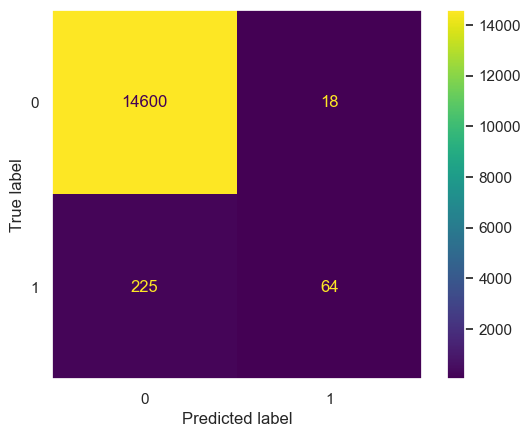

Accuracy         0.983699
F1               0.345013
Precision        0.780488
Recall           0.221453
ROC AUC Score    0.610111
dtype: float64


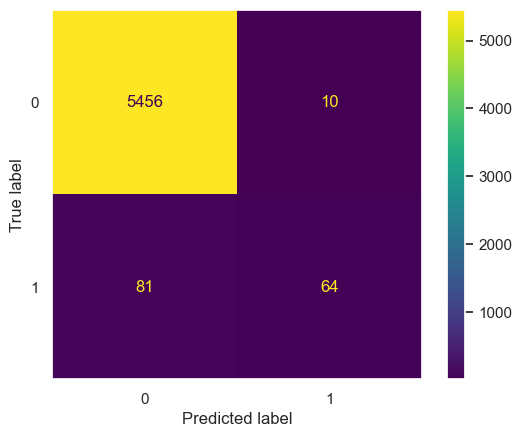

Accuracy         0.983782
F1               0.584475
Precision        0.864865
Recall           0.441379
ROC AUC Score    0.719775
dtype: float64


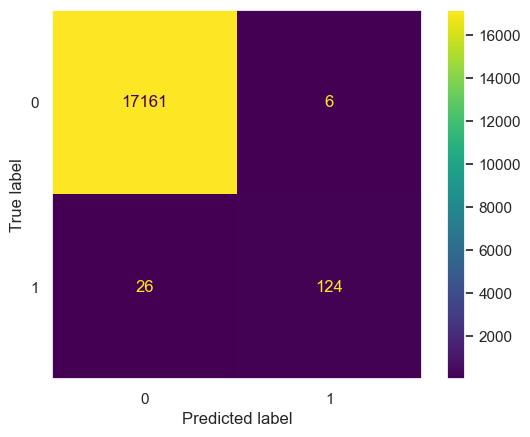

Accuracy         0.998152
F1               0.885714
Precision        0.953846
Recall           0.826667
ROC AUC Score    0.913159
dtype: float64


In [46]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData_['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=750, tree_method="hist", max_depth = 7,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

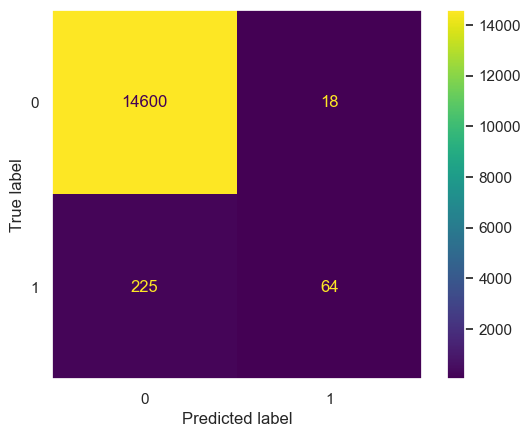

Accuracy         0.983699
F1               0.345013
Precision        0.780488
Recall           0.221453
ROC AUC Score    0.610111
dtype: float64


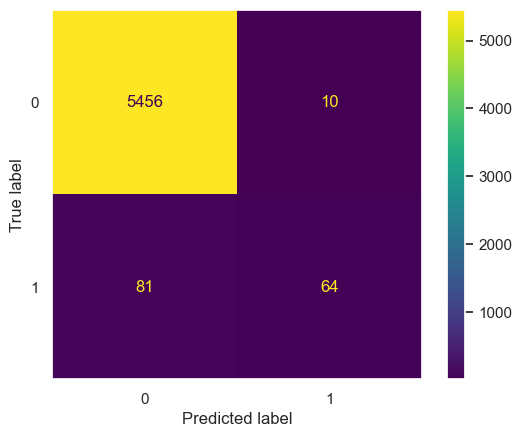

Accuracy         0.983782
F1               0.584475
Precision        0.864865
Recall           0.441379
ROC AUC Score    0.719775
dtype: float64


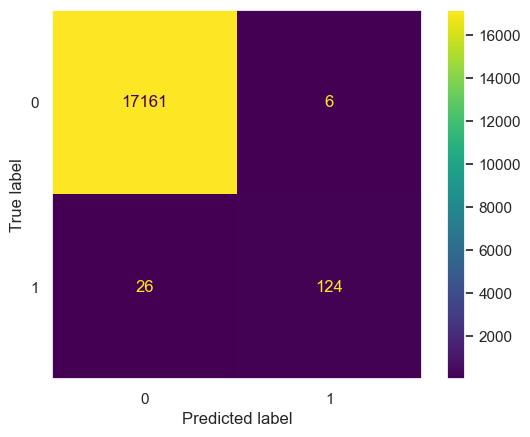

Accuracy         0.998152
F1               0.885714
Precision        0.953846
Recall           0.826667
ROC AUC Score    0.913159
dtype: float64


In [47]:
models = []
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData_['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=750, tree_method="hist", max_depth = 7,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))
    models.append([vTrainIdx , vTestIdx , xgbModel])

In [48]:
dfData_.iloc[models[-1][0]].shape , dfData_.iloc[models[-1][1]].shape

((20518, 190), (17317, 190))

In [ ]:
dfData_['Block Time'].dtype, dfData_['From Block Time'].dtype , dfData_['transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date'].dtype#, transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date
#dfData_['transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation']#.dtype


In [ ]:
dfData_['Block Time']

In [ ]:
pd.to_datetime(dfData_['transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation']).dt.tz_localize(None).astype(np.int64)


In [ ]:
dfData_['From Block Time'].astype(np.int64)
